In [1]:
# This file is part of the hessianlearn package
#
# hessianlearn is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or any later version.
#
# hessianlearn is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# If not, see <http://www.gnu.org/licenses/>.
#
# Author: Tom O'Leary-Roseberry
# Contact: tom.olearyroseberry@utexas.edu

# Hessianlearn tutorial 0: MNIST Autoencoder

In this tutorial, we look at how hessianlearn can be used to train a keras model.

We seek to learn a low dimensional representation of data (in this case handwritten MNIST images).

We build a simple autoencoder $f(x,w)$ which aims embed information about the handwritten images in a low dimensional space.

The training problem is empirical risk minimization over given dataset $X = \{x_i\}_{i=1}^N$:


$\text{min}_{w \in \mathbb{R}^{d_W}} L(w) = \frac{1}{2N}\sum\limits_{i=1}^N \| x_i - f(x_i,w)\|_2^2 $


This problem is typically ill-posed and often needs regularization, which is necessary for well posedness whenever the Hessian operator $\nabla^2 L(w)$ is rank deficient. The training problem is then posed as

$\text{min}_{w \in \mathbb{R}^{d_W}} L(w) + R(w)$

where $R(w)$ is a regularization operator. In this tutorial we will use Tikhonov regularization $R(w) = \frac{\gamma}{2}\|w\|_2^2$, for some coefficient $\gamma >0$.

## Structure of hessianlearn library

The optimization problem is solved iteratively. The key issues here are how to handle the data, the neural network, the loss function, the regularization, and the overall training.

### Data

The data $X=\{x_i\}_{i=1}^N$ is handled by an object called `Data`, which can be found in hessianlearn/data/data.py. This object takes a training data and testing data, stores it and iterates through the training data during training, and handles all subsampling. 

### NeuralNetworks: use keras

The convention as of September 2020 is to use keras for all neural network models $\{f(\cdot,w)\}$, and pass these models into hessianlearn constructs which handle differentiation, Hessian-vector products, and optimization routines for neural network training. 
In earlier versions of hessianlearn (based on tf1) hessianlearn used a neural network class `NeuralNetwork` which implements a callable function. This made the transition to keras simple, which also uses a callable framework. I am working on migrating everything to keras, but for now some neural network models still exist in the file hessianlearn/problem/neuralnetwork.py

### The loss function and regularization

In hessianlearn the loss function $L(w)$ is handled by a problem class (see hessianlearn/problem/problem.py), which takes a neural network into its constructor and handles the loss function as well as all derivatives of the loss function and functions for updating the weights during training. The idea is to have a different problem class for each problem, which inherents from the parent method `Problem`. Each new loss function must implement a method called `_initialize_loss`, and everything else is handled by the constructor of the base class `Parent`.

The regularization scheme is handled by a class `Regularization`. The key methods to implement here are `cost`, `gradient`, and the Hessian-vector product method `H_w_hat`.

### Optimization using the HessianlearnModel class

The neural network training can be done manually by the user, using a for loop and a tensorflow session `tensorflow.compat.v1.Session`, or can be handled by the `HessianlearnModel` class which abstracts the iterative optimization routine away to the method `fit`, as is done in keras (see hessianlearn/model/model.py).

This tutorial uses some code taken from [here](https://blog.keras.io/building-autoencoders-in-keras.html)

## Python Preamble

In [2]:
import numpy as np
import os, sys
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["KMP_WARNINGS"] = "FALSE" 
import time
# Import hessianlearn repository
sys.path.append( os.environ.get('HESSIANLEARN_PATH', "../../"))
from hessianlearn import *

Instructions for updating:
non-resource variables are not supported in the long term


## Instantiate the Data

In [3]:
settings = {}
settings['batch_size'] = 100
settings['hess_batch_size'] = 10

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# Reshape the data
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Instante the data object
data = Data([x_train,y_train],settings['batch_size'],\
            test_data = [x_test,y_test],hessian_batch_size = settings['hess_batch_size'])

## Create the neural network in keras

In [4]:
encoding_dim = 32  
input_img = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(encoding_dim, activation='softplus')(input_img)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Instantiate the problem and regularization in hessianlearn

In [5]:
problem = AutoencoderProblem(autoencoder,dtype=tf.float32)

settings['tikhonov_gamma'] = 0.0

regularization = L2Regularization(problem,gamma = settings['tikhonov_gamma'])



## Instantiate the HessianlearnModel
This object mimics the keras Model which handles training

In [6]:
HLModel = HessianlearnModel(problem,regularization,data)

HLModel.fit()

################################################################################
                       Size of configuration space: 50992                       
################################################################################
                  Using low rank SFN optimizer with fixed step                  
                                Batch size = 100                                
                            Hessian batch size = 10                             
                             Hessian low rank = 10                              
################################################################################
 Sweeps    Loss      acc train    ||g||      Loss_test   acc test    max test     alpha     
   0.00   2.3368e-01 -46.686% 3.1843e-02 2.3344e-01 -43.125% -43.125% 5.0000e-02
   1.00   2.9248e-02 49.797% 1.2838e-02 2.8079e-02 50.361% 50.930% 5.0000e-02
   2.00   1.8196e-02 60.298% 6.9523e-03 1.8869e-02 59.309% 59.309% 5.0000e-02
   3.00   2.0359e-02 5

## Postprocess the results

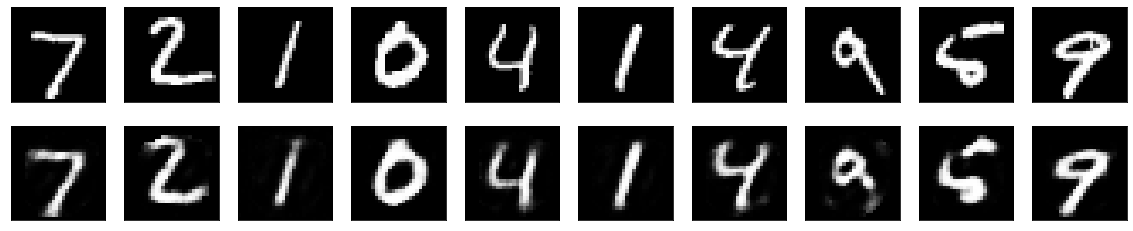

In [7]:
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(encoding_dim,))

decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()